In [1]:
import torch
import imp
import ppuu.costs
import ppuu.costs.policy_costs_km

imp.reload(ppuu.costs.policy_costs_km)

PolicyCostKMTaper = ppuu.costs.policy_costs_km.PolicyCostKMTaper

from ppuu.data.dataloader import DataStore, Dataset, Normalizer, UnitConverter
from ppuu import configs

store = DataStore('/home/us441/nvidia-collab/vlad/traffic-data-5/state-action-cost/data_i80_v0/')
ds = Dataset(store, 'train', 20, 30, 40, shift=False, random_actions=False)
loader = torch.utils.data.DataLoader(ds, batch_size=2)
normalizer = Normalizer(store.stats)

In [2]:
it = iter(loader)
batch = next(it)
print(batch)

DatasetSample(conditional_state_seq=StateSequence(images=tensor([[[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.1255, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.1255, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.1255, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

          [[0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
           [0.0000, 0.0000, 0.0000, 

torch.Size([2, 3, 117, 24])


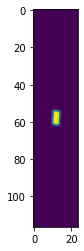

In [3]:
print(batch.conditional_state_seq.ego_car_image.shape)

from matplotlib import pyplot as plt

plt.imshow(batch.conditional_state_seq.ego_car_image[0, 2])

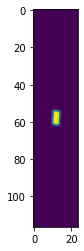

In [4]:
plt.imshow(batch.conditional_state_seq.with_ego().images[0, 0, 3])

In [5]:
image = batch.conditional_state_seq.images[:, 0]
state = batch.conditional_state_seq.states[:, 1]
batch.conditional_state_seq.shift_add(image, state)
batch.conditional_state_seq.with_ego().shift_add(image, state)

StateSequence(images=tensor([[[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.7216, 0.3765, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.7216, 0.3765, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.7216, 0.3765, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

          [[0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
           [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
     

# Forward Model 

In [18]:
batch.conditional_state_seq.car_size.shape

torch.Size([2, 2])

In [6]:
from ppuu.modeling.forward_models import FwdCNN

m = FwdCNN(layers=3, nfeature=256, dropout=0.1, h_height=14, h_width=3, height=117, width=24, n_actions=2, 
           hidden_size=256 * 14 * 3, ncond=20, predict_state=True)

In [7]:
res = m.forward(batch.conditional_state_seq, batch.target_action_seq, None)

In [8]:
res.images.shape

torch.Size([2, 30, 3, 117, 24])

In [9]:
res.states.shape

torch.Size([2, 30, 5])

# Forward Model with latent

In [10]:
from ppuu.modeling.forward_models import FwdCNN_VAE

m = FwdCNN_VAE(layers=3, nfeature=256, dropout=0.1, h_height=14, h_width=3, height=117, width=24, n_actions=2, 
               hidden_size=256 * 14 * 3, ncond=20, predict_state=True, nz=32, enable_kld=True, enable_latent=True)

In [12]:
res = m.forward(batch.conditional_state_seq, batch.target_action_seq, batch.target_state_seq)

In [13]:
res

ForwardResult(pred_images=tensor([[[[[0.4874, 0.4831, 0.4851,  ..., 0.4898, 0.4764, 0.4886],
           [0.4877, 0.4798, 0.4864,  ..., 0.4767, 0.4943, 0.4882],
           [0.4842, 0.4855, 0.4826,  ..., 0.4796, 0.4813, 0.4857],
           ...,
           [0.4876, 0.5770, 0.6381,  ..., 0.4887, 0.4837, 0.4960],
           [0.4942, 0.5765, 0.6460,  ..., 0.4735, 0.4858, 0.4749],
           [0.4887, 0.5722, 0.6363,  ..., 0.4940, 0.4841, 0.4884]],

          [[0.4976, 0.4893, 0.4914,  ..., 0.4808, 0.4932, 0.4906],
           [0.4913, 0.4802, 0.4762,  ..., 0.4962, 0.4855, 0.4918],
           [0.5004, 0.4912, 0.5013,  ..., 0.4850, 0.4905, 0.4868],
           ...,
           [0.4946, 0.4988, 0.6588,  ..., 0.4778, 0.4938, 0.4906],
           [0.4878, 0.5108, 0.6749,  ..., 0.5015, 0.5035, 0.4883],
           [0.4975, 0.5298, 0.6963,  ..., 0.4923, 0.5063, 0.4883]],

          [[0.4796, 0.4775, 0.4787,  ..., 0.7028, 0.7056, 0.7054],
           [0.4705, 0.4814, 0.4614,  ..., 0.7116, 0.7091, 0.7130],


In [16]:
m.unfold(batch.conditional_state_seq, batch.target_action_seq)

Unfolding(images=tensor([[[[[0.4844, 0.4847, 0.4747,  ..., 0.4798, 0.4874, 0.4871],
           [0.4881, 0.4793, 0.4904,  ..., 0.4818, 0.4881, 0.4888],
           [0.4917, 0.4657, 0.4937,  ..., 0.4724, 0.4906, 0.4861],
           ...,
           [0.4805, 0.5768, 0.6427,  ..., 0.4724, 0.4973, 0.4862],
           [0.4900, 0.5843, 0.6468,  ..., 0.4756, 0.4897, 0.4875],
           [0.4909, 0.5742, 0.6439,  ..., 0.4903, 0.4929, 0.4896]],

          [[0.4964, 0.4874, 0.4966,  ..., 0.4905, 0.4998, 0.4901],
           [0.4894, 0.4973, 0.4858,  ..., 0.4979, 0.4766, 0.4880],
           [0.5001, 0.4987, 0.4924,  ..., 0.4838, 0.4927, 0.4850],
           ...,
           [0.5040, 0.4934, 0.6624,  ..., 0.4796, 0.4929, 0.4938],
           [0.4865, 0.5052, 0.6831,  ..., 0.4969, 0.4831, 0.4875],
           [0.4989, 0.5182, 0.7016,  ..., 0.4781, 0.5076, 0.4864]],

          [[0.4680, 0.4755, 0.4708,  ..., 0.7093, 0.7003, 0.7086],
           [0.4727, 0.4790, 0.4726,  ..., 0.7149, 0.7054, 0.7186],
         

In [1]:
from ppuu.test.mock_dataset import get_mock_dataloader

In [2]:
dl = get_mock_dataloader()

In [4]:
next(iter(dl)).conditional_state_seq.images.shape

torch.Size([2, 20, 3, 117, 24])